# 라이브러리 및 함수 정의

In [1]:
import os
import warnings
warnings.filterwarnings('ignore')
from IPython.display import display

import pandas as pd
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import geopandas as gpd
from shapely.geometry import Polygon, Point 
import shapely # Shapely 형태의 데이터를 받아 내부 좌표들을 List안에 반환합니다. 
import numpy as np
from numpy import random

""" 스케일링 라이브러리 """
from sklearn.preprocessing import MinMaxScaler

""" 시각화 라이브러리 """
import pydeck as pdk
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = 'Nanum Gothic'
import cufflinks as cf 
cf.go_offline(connected=True)
cf.set_config_file(theme='polar')

from tqdm.notebook import tqdm

""" 최적화 solver 라이브러리 """
import time
from mip import Model, xsum, maximize, BINARY  

Using Python-MIP package version 1.5.3


In [2]:
""" Pydeck 사용을 위한 함수 정의 """

""" line string를 리스트로 변환하는 함수 """
def line_string_to_coordinates(line_string): 
    if isinstance(line_string, shapely.geometry.linestring.LineString): 
        lon, lat = line_string.xy 
        return [[x, y] for x, y in zip(lon, lat)] 
    elif isinstance(line_string, shapely.geometry.multilinestring.MultiLineString): 
        ret = [] 
        for i in range(len(line_string)): 
            lon, lat = line_string[i].xy 
            for x, y in zip(lon, lat): 
                ret.append([x, y])
        return ret 

""" multipolygon를 리스트로 변환하는 함수 """
def multipolygon_to_coordinates(x): 
    lon, lat = x[0].exterior.xy 
    return [[x, y] for x, y in zip(lon, lat)] 

""" polygon를 리스트로 변환하는 함수 """
def polygon_to_coordinates(x): 
    lon, lat = x.exterior.xy 
    return [[x, y] for x, y in zip(lon, lat)] 

""" 리스트로 변환하는 함수"""
def to_coordinates(x): 
    try: 
        lon, lat = x[0].exterior.xy 
    except:
        lon, lat = x.exterior.xy 
    return [[x, y] for x, y in zip(lon, lat)] 

In [3]:
""" geometry 관련 변수 생성하는 함수 """
def geo(df):
    # 100X100 grid에서 central point 찾기
    df_list = []
    df_list2 = []
    for i in df['geometry']:
        cent = [[i[0].centroid.coords[0][0],i[0].centroid.coords[0][1]]]
        df_list.append(cent)
        df_list2.append(Point(cent[0]))
    df['coord_cent'] = 0
    df['geo_cent'] = 0
    df['coord_cent']= pd.DataFrame(df_list) # pydeck을 위한 coordinate type
    df['geo_cent'] = df_list2 # geopandas를 위한 geometry type
    return df

In [4]:
""" mclp 모델 사용을 위한 함수 정의 """

""" 후보지 선정하는 함수(우리는 전체 후보지 사용함, 코드 그대로 사용하기 위함) """
def generate_candidate_sites(df_dodam,Weight,M=100):
    sites = []
    idx = df_dodam.sort_values(by = Weight, ascending = False).iloc[1:M].index
    for i in range(len(idx)):
        random_point = Point(np.array(df_dodam.loc[idx]['coord_cent'])[i][0],
                             np.array(df_dodam.loc[idx]['coord_cent'])[i][1])
        sites.append(random_point)
    return np.array([(p.x,p.y) for p in sites])

from scipy.spatial import distance_matrix


""" mclp 함수 """
def mclp(points,K,radius,M,df_dodam,w,Weight):

    """
    Solve maximum covering location problem
    Input:
        points: input points, Numpy array in shape of [N,2]
        K: the number of sites to select
        radius: the radius of circle
        M: the number of candidate sites, which will randomly generated inside
        the ConvexHull wrapped by the polygon
    Return:
        opt_sites: locations K optimal sites, Numpy array in shape of [K,2]
        f: the optimal value of the objective function
    """
    print('----- Configurations -----')
    print('  Number of points %g' % points.shape[0])
    print('  K %g' % K)
    print('  Radius %g' % radius)
    print('  M %g' % M)
    import time
    start = time.time()
    sites = generate_candidate_sites(df_dodam,Weight,M)
    J = sites.shape[0]
    I = points.shape[0]
    D = distance_matrix(points,sites)
    mask1 = D<=radius
    D[mask1]=1
    D[~mask1]=0

    from mip import Model, xsum, maximize, BINARY

    # Build model
    m = Model("mclp")
    
    # Add variables

    x = [m.add_var(name = "x%d" % j, var_type = BINARY) for j in range(J)]
    y = [m.add_var(name = "y%d" % i, var_type = BINARY) for i in range(I)]


    m.objective = maximize(xsum(w[i]*y[i] for i in range (I)))

    m += xsum(x[j] for j in range(J)) == K

    for i in range(I):
        m += xsum(x[j] for j in np.where(D[i]==1)[0]) >= y[i]

    m.max_gap = 0.05
    m.optimize(max_seconds=300)
    
    end = time.time()
    print('----- Output -----')
    print('  Running time : %s seconds' % float(end-start))
    print('  Optimal coverage points: %g' % m.objective_value)

    solution = []
    for i in range(J):
        if x[i].x ==1:
            solution.append(int(x[i].name[1:]))
    opt_sites = sites[solution]
            
    return opt_sites,m.objective_value

# 데이터 불러오기

In [5]:
""" 데이터 불러오기 """
df_dodam = gpd.read_file('df_dodam.geojson')
df_saerom = gpd.read_file('df_saerom.geojson')
df_jochi = gpd.read_file('df_jochi.geojson')

# df_dodam.info()
# df_saerom.info()
# df_jochi.info()

# df_dodam.shape  # (734, 4)
# df_saerom.shape  # (317, 4)
# df_jochi.shape  # (674, 4)

In [6]:
""" geometry 관련 변수 생성 """
df_dodam = geo(df_dodam)
df_saerom = geo(df_saerom)
df_jochi = geo(df_jochi)

# mclp 최적화
- 조치원읍 / 도담동 / 새롬동의 이동노동자를 최대로 cover하는 입지 최적화

## ① 도담동

In [7]:
points = []
for i in df_dodam['coord_cent'] :
    points.append(i)

w= []
for i in df_dodam['tot_val'] :
    w.append(1)

    
설치지역 = []
for i in [500,600,700,800,900]:
    radius = radius = (1/88.74/1000)*i
    K = 4
    M = len(df_dodam)
    opt_sites_org,f = mclp(np.array(points),K,radius,M,df_dodam,w,'tot_val')
    설치지역.append([i,f/len(points)])

----- Configurations -----
  Number of points 734
  K 4
  Radius 0.00563444
  M 734
----- Output -----
  Running time : 29.786698579788208 seconds
  Optimal coverage points: 375
----- Configurations -----
  Number of points 734
  K 4
  Radius 0.00676133
  M 734
----- Output -----
  Running time : 28.317471027374268 seconds
  Optimal coverage points: 495
----- Configurations -----
  Number of points 734
  K 4
  Radius 0.00788821
  M 734
----- Output -----
  Running time : 28.345762252807617 seconds
  Optimal coverage points: 577
----- Configurations -----
  Number of points 734
  K 4
  Radius 0.0090151
  M 734
----- Output -----
  Running time : 28.52208638191223 seconds
  Optimal coverage points: 633
----- Configurations -----
  Number of points 734
  K 4
  Radius 0.010142
  M 734
----- Output -----
  Running time : 28.4751398563385 seconds
  Optimal coverage points: 686


,covered distance (m),The Ratio of Coverage Points
0,500,0.510899
1,600,0.674387
2,700,0.786104
3,800,0.862398
4,900,0.934605


findfont: Font family ['Nanum Gothic'] not found. Falling back to DejaVu Sans.


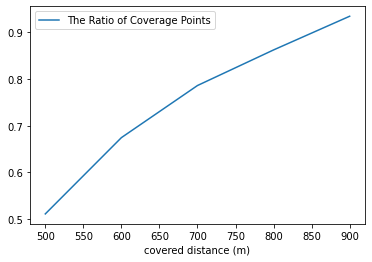

In [8]:
설치지역 = pd.DataFrame(설치지역)
설치지역.columns = ['covered distance (m)', 'The Ratio of Coverage Points']

설치지역.plot('covered distance (m)','The Ratio of Coverage Points')
설치지역

In [9]:
points = []
for i in df_dodam['coord_cent'] :
    points.append(i)

w= []
for i in df_dodam['tot_val'] :
    w.append(i)

radius = radius = (1/88.74/1000)*800   
K = 4
M = len(df_dodam)
opt_sites_org,f = mclp(np.array(points),K,radius,M,df_dodam,w,'tot_val')

lonlat_dodam = pd.DataFrame(opt_sites_org)
lonlat_dodam.columns = ['lon', 'lat']
lonlat_dodam

----- Configurations -----
  Number of points 734
  K 4
  Radius 0.0090151
  M 734
----- Output -----
  Running time : 28.150017023086548 seconds
  Optimal coverage points: 749.198


,lon,lat
0,127.257597,36.513616
1,127.271015,36.508233
2,127.260995,36.498297
3,127.265368,36.528957


In [10]:
""" 데이터 내보내기 """
lonlat_dodam.to_csv("lonlat_dodam.csv")

## ② 조치원읍

In [11]:
points = []
for i in df_jochi['coord_cent'] :
    points.append(i)

w= []
for i in df_jochi['tot_val'] :
    w.append(1)

    
설치지역 = []
for i in [500,600,700,800,900]:
    radius = radius = (1/88.74/1000)*i
    K = 4
    M = len(df_jochi)
    opt_sites_org,f = mclp(np.array(points),K,radius,M,df_jochi,w,'tot_val')
    설치지역.append([i,f/len(points)])

----- Configurations -----
  Number of points 674
  K 4
  Radius 0.00563444
  M 674
----- Output -----
  Running time : 31.08943486213684 seconds
  Optimal coverage points: -343
----- Configurations -----
  Number of points 674
  K 4
  Radius 0.00676133
  M 674
----- Output -----
  Running time : 27.65043044090271 seconds
  Optimal coverage points: 432
----- Configurations -----
  Number of points 674
  K 4
  Radius 0.00788821
  M 674
----- Output -----
  Running time : 26.844812393188477 seconds
  Optimal coverage points: 519
----- Configurations -----
  Number of points 674
  K 4
  Radius 0.0090151
  M 674
----- Output -----
  Running time : 26.97158408164978 seconds
  Optimal coverage points: 568
----- Configurations -----
  Number of points 674
  K 4
  Radius 0.010142
  M 674
----- Output -----
  Running time : 27.098971366882324 seconds
  Optimal coverage points: 615


,covered distance (m),The Ratio of Coverage Points
0,500,-0.508902
1,600,0.640950
2,700,0.770030
3,800,0.842730
4,900,0.912463


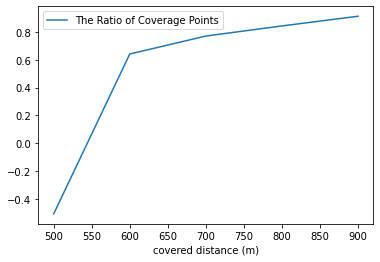

In [12]:
설치지역 = pd.DataFrame(설치지역)
설치지역.columns = ['covered distance (m)', 'The Ratio of Coverage Points']

설치지역.plot('covered distance (m)','The Ratio of Coverage Points')
설치지역

In [13]:
points = []
for i in df_jochi['coord_cent'] :
    points.append(i)

w= []
for i in df_jochi['tot_val'] :
    w.append(i)

radius = radius = (1/88.74/1000)*800   
K = 4
M = len(df_jochi)
opt_sites_org,f = mclp(np.array(points),K,radius,M,df_jochi,w,'tot_val')

lonlat_jochi = pd.DataFrame(opt_sites_org)
lonlat_jochi.columns = ['lon', 'lat']
lonlat_jochi

----- Configurations -----
  Number of points 674
  K 4
  Radius 0.0090151
  M 674
----- Output -----
  Running time : 28.921120405197144 seconds
  Optimal coverage points: 352.346


,lon,lat
0,127.298690,36.602040
1,127.283039,36.601111
2,127.293136,36.588508
3,127.293066,36.614651


In [14]:
""" 데이터 내보내기 """
lonlat_jochi.to_csv("lonlat_jochi.csv")

## ③ 새롬동

In [15]:
points = []
for i in df_saerom['coord_cent'] :
    points.append(i)

w= []
for i in df_saerom['tot_val'] :
    w.append(1)

    
설치지역 = []
for i in [500,600,700,800,900]:
    radius = radius = (1/88.74/1000)*i
    K = 2
    M = len(df_saerom)
    opt_sites_org,f = mclp(np.array(points),K,radius,M,df_saerom,w,'tot_val')
    설치지역.append([i,f/len(points)])

----- Configurations -----
  Number of points 317
  K 2
  Radius 0.00563444
  M 317
----- Output -----
  Running time : 13.818101406097412 seconds
  Optimal coverage points: 192
----- Configurations -----
  Number of points 317
  K 2
  Radius 0.00676133
  M 317
----- Output -----
  Running time : 14.332342624664307 seconds
  Optimal coverage points: 256
----- Configurations -----
  Number of points 317
  K 2
  Radius 0.00788821
  M 317
----- Output -----
  Running time : 13.731642246246338 seconds
  Optimal coverage points: 289
----- Configurations -----
  Number of points 317
  K 2
  Radius 0.0090151
  M 317
----- Output -----
  Running time : 13.955183982849121 seconds
  Optimal coverage points: 306
----- Configurations -----
  Number of points 317
  K 2
  Radius 0.010142
  M 317
----- Output -----
  Running time : 13.822887659072876 seconds
  Optimal coverage points: 315


,covered distance (m),The Ratio of Coverage Points
0,500,0.605678
1,600,0.807571
2,700,0.911672
3,800,0.965300
4,900,0.993691


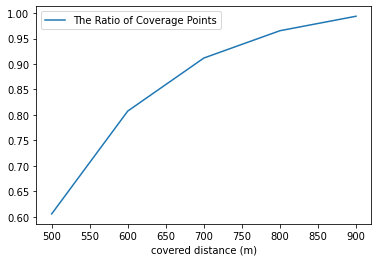

In [16]:
설치지역 = pd.DataFrame(설치지역)
설치지역.columns = ['covered distance (m)', 'The Ratio of Coverage Points']

설치지역.plot('covered distance (m)','The Ratio of Coverage Points')
설치지역

In [17]:
points = []
for i in df_saerom['coord_cent'] :
    points.append(i)

w= []
for i in df_saerom['tot_val'] :
    w.append(i)

radius = radius = (1/88.74/1000)*800   
K = 2
M = len(df_saerom)
opt_sites_org,f = mclp(np.array(points),K,radius,M,df_saerom,w,'tot_val')

lonlat_saerom = pd.DataFrame(opt_sites_org)
lonlat_saerom.columns = ['lon', 'lat']
lonlat_saerom

----- Configurations -----
  Number of points 317
  K 2
  Radius 0.0090151
  M 317
----- Output -----
  Running time : 13.640875339508057 seconds
  Optimal coverage points: 435.468


,lon,lat
0,127.248759,36.483848
1,127.262144,36.487481


In [18]:
""" 데이터 내보내기 """
lonlat_saerom.to_csv("lonlat_saerom.csv")

## 시각화

In [19]:
""" 데이터 합치기 """
df_total = pd.concat([df_dodam,df_saerom,df_jochi], ignore_index=True)
lonlat_total = pd.concat([lonlat_dodam,lonlat_saerom,lonlat_jochi], ignore_index=True)

In [20]:
""" coordinates 변수 생성 """
df_total['coordinates'] = df_total['geometry'].apply(multipolygon_to_coordinates) #pydeck 을 위한 coordinate type

""" lat_min, lat_max, lon_min, lon_max 변수 생성 """
lat_min = []
lat_max = []
lon_min = []
lon_max = []
for i in range(len(df_total)):  
    lon_min.append(df_total['coordinates'][i][0][0])
    lon_max.append(df_total['coordinates'][i][1][0])
    lat_min.append(df_total['coordinates'][i][2][1])
    lat_max.append(df_total['coordinates'][i][0][1])
df_total['lon_min'] = lon_min
df_total['lon_max'] = lon_max
df_total['lat_min'] = lat_min
df_total['lat_max'] = lat_max

In [21]:
df_total.head()

,id,dong,tot_val,geometry,coord_cent,geo_cent,coordinates,lon_min,lon_max,lat_min,lat_max
0,42126.0,도담동,0.834615,"MULTIPOLYGON (((127.25710 36.49513, 127.25821 ...","[127.25765595394668, 36.49468412283486]",POINT (127.2576559539467 36.49468412283486),"[[127.25709627500409, 36.495133743822834], [12...",127.257096,127.258213,36.494235,36.495134
1,42127.0,도담동,0.838462,"MULTIPOLYGON (((127.25710 36.49423, 127.25822 ...","[127.257658762684, 36.493782611149065]",POINT (127.257658762684 36.49378261114907),"[[127.2570990902741, 36.49423223224252], [127....",127.257099,127.258216,36.493333,36.494232
2,42124.0,도담동,0.830769,"MULTIPOLYGON (((127.25709 36.49694, 127.25821 ...","[127.25765033609753, 36.49648714579628]",POINT (127.2576503360975 36.49648714579628),"[[127.25709064408868, 36.49693676657332], [127...",127.257091,127.258207,36.496038,36.496937
3,42125.0,도담동,0.983401,"MULTIPOLYGON (((127.25709 36.49604, 127.25821 ...","[127.25765314508455, 36.49558563438393]",POINT (127.2576531450845 36.49558563438393),"[[127.25709345960895, 36.496035255266435], [12...",127.257093,127.258210,36.495136,36.496035
4,42122.0,도담동,0.826923,"MULTIPOLYGON (((127.25709 36.49874, 127.25820 ...","[127.25764471774896, 36.498290168210865]",POINT (127.257644717749 36.49829016821086),"[[127.25708501267265, 36.49873978877693], [127...",127.257085,127.258202,36.497841,36.498740


In [22]:
""" 데이터프레임으로 변환(pydeck은 pandas.dataframe만 인식) """
df_total = pd.DataFrame(df_total).reset_index(drop = True)
lonlat_total = pd.DataFrame(lonlat_total).reset_index(drop = True)

In [23]:
""" mapbox api token """
MAPBOX_API_KEY = "pk.eyJ1IjoiZG9yYWtpbSIsImEiOiJja3R4bmwyb3ExNWdvMndxbWd5ZzZhYmw1In0.K5CTJ8_8pLhdwxKLrkK4hQ"

In [24]:
""" icon layer 생성 """
icon_data = {
    # Icon from Wikimedia, used the Creative Commons Attribution-Share Alike 3.0
    # Unported, 2.5 Generic, 2.0 Generic and 1.0 Generic licenses
    "url": "https://upload.wikimedia.org/wikipedia/commons/1/11/%EC%9C%84%EC%B9%98_%ED%91%9C%EC%8B%9C.png",
    "width": 242,
    "height": 242,
    "anchorY": 242,
}

lonlat_total["icon_data"] = None
for i in lonlat_total.index:
    lonlat_total["icon_data"][i] = icon_data
    
lotlat_sign = pdk.Layer(
    type="IconLayer",
    data=lonlat_total,
    get_icon="icon_data",
    get_size=2,
    size_scale=7,
    get_position=["lon", "lat"],
    pickable=True,
)

In [25]:
""" grid layer 생성"""
layer = pdk.Layer(
    'PolygonLayer', # 사용할 Layer 타입
    df_total, # 시각화에 쓰일 데이터프레임
    get_polygon = 'coordinates', # geometry 정보를 담고있는 컬럼 이름
    get_fill_color = '[100*tot_val, 50, 50, 255]', # 각 데이터 별 rgb 또는 rgba 값 (0~255)
    pickable = True, # 지도와 interactive 한 동작 on
    auto_highlight = True # 마우스 오버(hover) 시 박스 출력
)

In [26]:
""" viewpoint 지정 """
center = [127.271533, 36.592541]
view_state = pdk.ViewState(
    longitude = center[0],
    latitude = center[1],
    zoom = 10)

In [27]:
""" render """
r = pdk.Deck(
             layers = [layer,lotlat_sign], 
             initial_view_state = view_state,
             map_style='mapbox://styles/mapbox/outdoors-v11',
             mapbox_key = MAPBOX_API_KEY)
# r.show()
r.to_html("final.html")